<img src="../images/logo.jpg" style="width:85px;height:85px;float:left" /><h1 style="position:relative;float:left;display:inline">Conditional GAN from Scratch</h1>

<a href='https://colab.research.google.com/github/zurutech/gans-from-theory-to-production/blob/master/2.%20GANs%20in%20Tensorflow/BONUS%20-%20Conditional%20GAN%20from%20scratch.ipynb'>
    <img align="left" src='https://cdn-images-1.medium.com/max/800/1*ZpNn76K98snC9vDiIJ6Ldw.jpeg'></img>
</a>

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython import display
import random
import pylab as pl

Define a Interactive Session 


In [2]:
sess = tf.InteractiveSession()

Define the dataset size and the 2 random normal distribution

In [3]:
dataset_size = 2000

z_1 = tf.random_normal(mean=10., shape=(), stddev=0.1, dtype=tf.float32)
z_2 = tf.random_normal(mean=20., shape=(), stddev=0.2, dtype=tf.float32)

Define the labels for the two distributions

In [4]:
l = np.zeros(shape=(dataset_size, 1), dtype=np.float32)
l2 = np.ones(shape=(dataset_size, 1), dtype=np.float32)

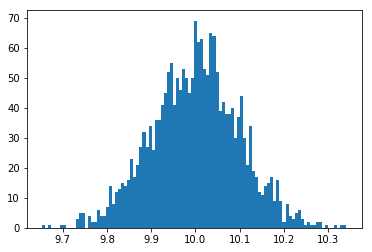

In [5]:
# distribution 1
z_samples_1 = [sess.run(z_1) for _ in range(dataset_size)]
counts, bin, ignored = plt.hist(z_samples_1, 100)

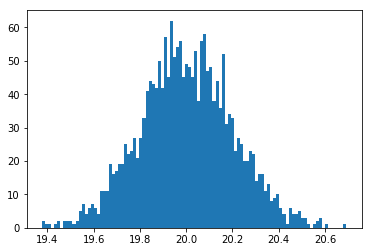

In [6]:
# distribution 2
z_samples_2 = [sess.run(z_2) for _ in range(dataset_size)]
counts, bin, ignored = plt.hist(z_samples_2, 100)

Define the generator and discriminator function 

This time the generator and the discriminator have an additional parameter...

In [7]:
def generator(z, label):
    """generator network.
    Args:
        z: a (None, latent_space_size) tf.float32 tensor
        label: a (None, 1) 
    Returns:
        G: the generator output node
    """
    with tf.variable_scope("generator"):
        inputs = tf.concat(axis=1, values=[z, label])
        fc1 = tf.layers.dense(inputs, units=64, activation=tf.nn.elu, name="fc1")
        fc2 = tf.layers.dense(fc1, units=64, activation=tf.nn.elu, name="fc2")
        G = tf.layers.dense(fc1, units=1, name="G")
    return G
    
def disciminator(x, label, reuse=False):
    """discriminator network.
    Args:
        inputs: a (None, 1) tf.float32 tensor
        label: a (None, 1)
        reuse: python boolean, if we expect to reuse (True) or declare (False) the variables
    Returns:
        D: the discriminator output node
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        inputs = tf.concat(axis=1, values=[x, label])
        fc1 = tf.layers.dense(inputs, units=32, activation=tf.nn.elu, name="fc1")
        D = tf.layers.dense(fc1, units=1, name="D")
    return D

def generator(input_shape, condition_shape):
    """generator network.
    Args:
        input_shape: the desired input shape (e.g.: (latent_space_size))
        condition_shape: the shape of the condition 
    Returns:
        G: The generator model
    """
    inputs = tf.keras.layers.Input(input_shape)
    condition_inputs = tf.keras.layers.Input(condition_shape)
    net = tf.keras.layers.concatenate([inputs, condition_inputs])
    net = tf.keras.layers.Dense(units=64, activation=tf.nn.elu, name="fc1")(net)
    net = tf.keras.layers.Dense(units=64, activation=tf.nn.elu, name="fc2")(net)
    net = tf.keras.layers.Dense(units=1, name="G")(net)
    G = tf.keras.Model(inputs=[inputs, condition_inputs], outputs=net)
    return G
    
def disciminator(input_shape, condition_shape):
    """discriminator network.
    Args:
        input_shape: the desired input shape (e.g.: (latent_space_size))
        condition_shape: the shape of the condition
    Returns:
        D: the discriminator model
    """
    inputs = tf.keras.layers.Input(input_shape)
    condition_inputs = tf.keras.layers.Input(condition_shape)
    net = tf.keras.layers.concatenate([inputs, condition_inputs])
    
    net = tf.keras.layers.Dense(units=32, activation=tf.nn.elu, name="fc1")(net)
    net = tf.keras.layers.Dense(units=1, name="D")(net)
    D = tf.keras.Model(inputs=[inputs, condition_inputs], outputs=net)
    return D

Define the generator and discriminator - together with the conditional inputs

In [8]:
#Define the real input(and label), a batch of values sampled from the real data (our N(10,0.1) or N(20, 0.2) distributions)
real_input = tf.placeholder(tf.float32, shape=(None,1))
real_label = tf.placeholder(tf.float32, shape=(None,1))

# Define the discriminator network and its parameters
D = disciminator(real_input.shape[1:], real_label.shape[1:])
D_real = D(inputs=[real_input, real_label])

# Arbitrary set the shape of the noise prior (vector of 100 values sampled from a N(0,1) distribution)
latent_space_size = 100

# Define the input noise shape and the generator
input_noise = tf.placeholder(tf.float32, shape=(None,latent_space_size))
G = generator(input_noise.shape[1:], real_label.shape[1:])

G_z = G(inputs=[input_noise, real_label])
D_fake = D(inputs=[G_z, real_label])

Define the discriminator loss

In [9]:
D_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real, labels=tf.ones_like(D_real))
)

D_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.zeros_like(D_fake))
)

D_loss = D_loss_real + D_loss_fake

Define the generator loss

In [10]:
G_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.ones_like(D_fake))
)

Define the optimizers for the train

In [11]:
# Define the optimizers and the train operations
train_D = tf.train.AdamOptimizer(1e-5).minimize(D_loss, var_list=D.trainable_variables)
train_G = tf.train.AdamOptimizer(1e-5).minimize(G_loss, var_list=G.trainable_variables)

In [12]:
real_data_1 = np.expand_dims(np.array(z_samples_1),1) # mu=10, mean=0.1, training_set size samples

In [13]:
real_data_2 = np.expand_dims(np.array(z_samples_2),1) # mu=20, mean=0.2, training_set size samples

Train the CGAN

In [14]:
#initialize the variables before running the session
sess.run(tf.global_variables_initializer())

# Let's play the min-max game
for step in range(40000):
    noise_vector = np.random.normal(loc=0, scale=1, size=(dataset_size, latent_space_size))
    
    #real_data, real_label = tf.cond(tf.equal((step % 2), 1) , lambda: f1, lambda: f2)
     
    # Train the disciminator
    _, d_loss_value = sess.run([train_D, D_loss], feed_dict={real_input: real_data_1, real_label: l, input_noise: noise_vector})
    
    # Train the generator
    _, g_loss_value = sess.run([train_G, G_loss], feed_dict={input_noise: noise_vector, real_label: l})
    
    noise_vector_1 = np.random.normal(loc=0, scale=1, size=(dataset_size, latent_space_size))
    
    _, d_loss_value = sess.run([train_D, D_loss], feed_dict={real_input: real_data_2, real_label: l2, input_noise: noise_vector_1})

    # Train the generator
    _, g_loss_value = sess.run([train_G, G_loss], feed_dict={input_noise: noise_vector_1, real_label: l2})
    
    if step % 5000 == 0:
        print("G loss: ", g_loss_value, " D loss: ", d_loss_value, " step: ", step)        

G loss:  0.5866199  D loss:  2.018352  step:  0
G loss:  0.76831144  D loss:  1.3993706  step:  5000
G loss:  0.7106116  D loss:  1.3792868  step:  10000
G loss:  0.69704795  D loss:  1.3800049  step:  15000
G loss:  0.69523656  D loss:  1.3854004  step:  20000
G loss:  0.69420195  D loss:  1.3859173  step:  25000
G loss:  0.6943783  D loss:  1.3861954  step:  30000
G loss:  0.69324315  D loss:  1.3862779  step:  35000


In [15]:
noise_vector = np.random.normal(loc=0, scale=1, size=(dataset_size, latent_space_size))

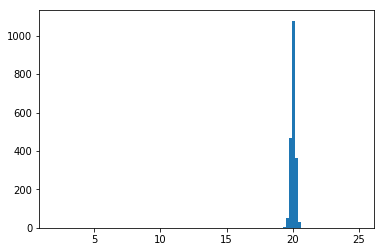

In [20]:
sampled = sess.run(G_z, feed_dict={input_noise: noise_vector, real_label: l2})

counts, bin, ignored = plt.hist(sampled, 100, range=(2, 25))

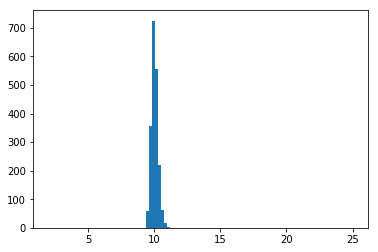

In [21]:
sampled = sess.run(G_z, feed_dict={input_noise: noise_vector, real_label: l})

counts, bin, ignored = plt.hist(sampled, 100, range=(2, 25))